In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import norm
from sklearn import cluster
from sklearn.mixture import BayesianGaussianMixture

In [2]:
 np.random.seed(0)

In [3]:
def forward(obs, transition_probability, emission_probability, start_probability):
    T = len(obs)
    N = transition_probability.shape[0]
    alpha = np.zeros((T, N))
    alpha[0] = emission_probability[:, obs[0]] * start_probability
    for i in range(1, T):
        alpha[i] = emission_probability[:, obs[i]] * np.inner(alpha[i - 1], transition_probability)
    return alpha


In [4]:
data_file = "../../data/sp500w.csv"
df = pd.read_csv(data_file)
print('Number of rows:',len(df))
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

Number of rows: 509


,Close
0,0.037213
1,0.020674
2,-0.028198
3,-0.045812
4,-0.006639


In [5]:
df = df[df["Close"] > -0.2]

In [6]:
dr = pd.date_range(start="1/1/2000", end="31/12/2015", freq="BY")
dr = dr.date.astype('O')
dr

array([datetime.date(2000, 12, 29), datetime.date(2001, 12, 31),
       datetime.date(2002, 12, 31), datetime.date(2003, 12, 31),
       datetime.date(2004, 12, 31), datetime.date(2005, 12, 30),
       datetime.date(2006, 12, 29), datetime.date(2007, 12, 31),
       datetime.date(2008, 12, 31), datetime.date(2009, 12, 31),
       datetime.date(2010, 12, 31), datetime.date(2011, 12, 30),
       datetime.date(2012, 12, 31), datetime.date(2013, 12, 31),
       datetime.date(2014, 12, 31), datetime.date(2015, 12, 31)],
      dtype=object)

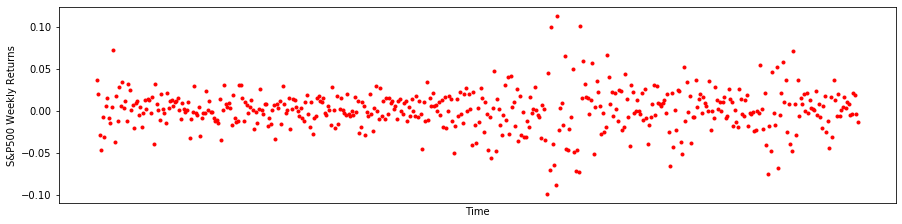

In [7]:
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(np.arange(len(df)), df["Close"], ".", color="red", label="SP500");
ax.set_ylabel("S&P500 Weekly Returns")
ax.set_xlabel("Time")
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.show()

In [8]:
df.describe()

,Close
count,508.000000
mean,0.001376
std,0.024528
min,-0.098709
25%,-0.009952
50%,0.001816
75%,0.014384
max,0.113559


/Users/yg/anaconda3/envs/mylab2env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


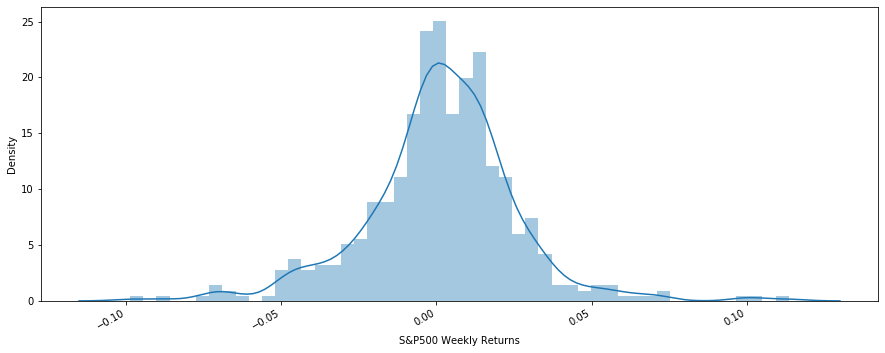

In [9]:
fig, ax = plt.subplots(figsize=(15,6))
sns.distplot(df["Close"], bins=50, ax=ax, kde=True)
ax.set_xlabel("S&P500 Weekly Returns")
ax.set_ylabel("Density")
fig.autofmt_xdate()
plt.show()

In [11]:
data = np.array(df["Close"]).reshape(-1,1)

In [12]:
gmm = BayesianGaussianMixture(n_components=3, init_params="kmeans", max_iter=1500)
gmm.fit(data)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1500, mean_precision_prior=None,
                        mean_prior=None, n_components=3, n_init=1,
                        random_state=None, reg_covar=1e-06, tol=0.001,
                        verbose=0, verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [13]:
gmm.converged_

True

In [14]:
gmm.means_

array([[ 0.00496639],
       [-0.01426084],
       [ 0.00483315]])

In [122]:
def plot_gaussian(means, covars, curve_ind=0):
    fig, ax = plt.subplots(figsize=(15, 4))
    # means = np.array([0.004, -0.34, -0.003])
    ind = means.argsort()[-3:][::-1]
    means = means[ind]
    print("Mean={}".format(means))
    # stds = np.array([.014, .009, .044])
    covars = covars[ind]
    print("Covars={}".format(covars))
    x1 = np.linspace(means[0] - 2 * covars[0], means[0] + 2* covars[0], 100)
    x2 = np.linspace(means[1] - 2 * covars[1], means[1] + 2* covars[1], 100)
    x3 = np.linspace(means[2] - 2 * covars[2], means[2] + 2* covars[2], 100)
    if curve_ind == 0:
        ax.plot(x1, norm.pdf(x1, means[0], covars[0]), ".", color="grey")
    elif curve_ind == 1:
        ax.plot(x2, norm.pdf(x2, means[1], covars[1]), ".", color="blue")
    else:
        ax.plot(x3, norm.pdf(x3, means[2], covars[2]), ".", color="red")
    ax.set_xlabel("S&P500 Weekly Returns")
    ax.set_ylabel("Density")
    plt.show()

In [113]:
y = np.array([4,8,16])
np.sqrt(y)

array([2.        , 2.82842712, 4.        ])

Mean=[ 0.00496639  0.00483315 -0.01426084]
Covars=[0.00168781 0.00019083 0.00067301]


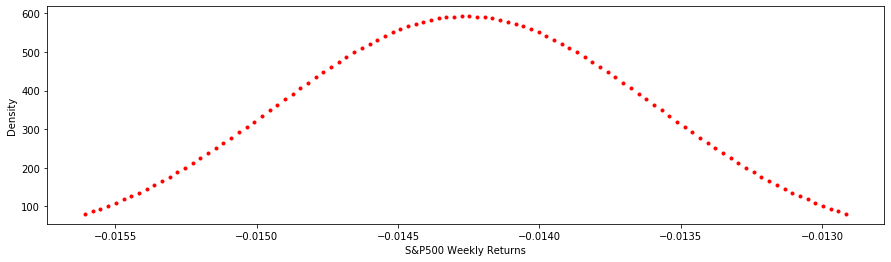

In [105]:
plot_gaussian(gmm.means_.flatten(), gmm.covariances_.flatten(), curve_ind=3)

In [86]:
np.eye(1).shape

(1, 1)

Mean=[ 0.00514982 -0.00136042 -0.00796298]
Covars=[0.01325707 0.03874765 0.020008  ]


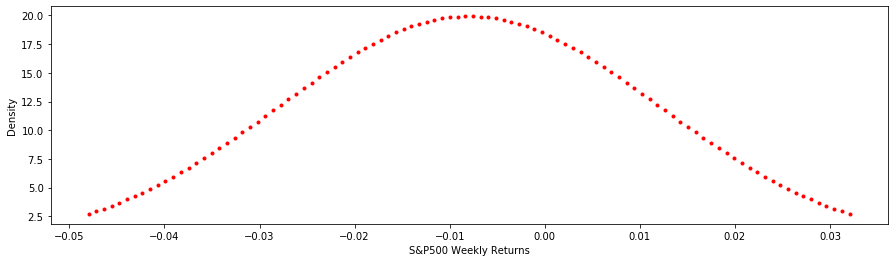

In [117]:
means=np.array([-0.00796298, -0.00136042, 0.00514982])
covars = np.array([0.00040032, 0.00150138, 0.00017575])
plot_gaussian(means, np.sqrt(covars), curve_ind=3)

In [123]:
def plot_gaussian_2(means, covars, curve_ind=0):
    fig, ax = plt.subplots(figsize=(15, 4))
    # means = np.array([0.004, -0.34, -0.003])
    ind = means.argsort()[-3:][::-1]
    means = means[ind]
    print("Mean={}".format(means))
    # stds = np.array([.014, .009, .044])
    covars = covars[ind]
    print("Covars={}".format(covars))
    x1 = np.linspace(means[0] - 2 * covars[0], means[0] + 2* covars[0], 100)
    x2 = np.linspace(means[1] - 2 * covars[1], means[1] + 2* covars[1], 100)
    x3 = np.linspace(means[2] - 2 * covars[2], means[2] + 2* covars[2], 100)
    sns.distplot(df["Close"], bins=50, ax=ax, kde=True)
    ax.plot(x1, norm.pdf(x1, means[0], covars[0]), ".", color="grey")
    ax.plot(x2, norm.pdf(x2, means[1], covars[1]), ".", color="blue")
    ax.plot(x3, norm.pdf(x3, means[2], covars[2]), ".", color="red")
    ax.set_xlabel("S&P500 Weekly Returns")
    ax.set_ylabel("Density")
    plt.show()

Mean=[ 0.00514982 -0.00136042 -0.00796298]
Covars=[0.01325707 0.03874765 0.020008  ]


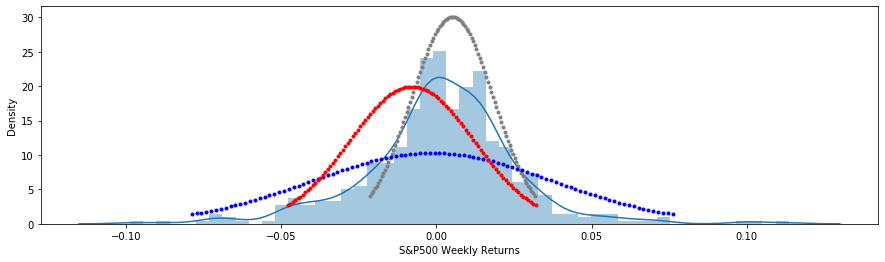

In [124]:
plot_gaussian_2(means, np.sqrt(covars), curve_ind=3)